Which countries have flags that are predominantly red and white?
-------------

In [2]:
% matplotlib inline
import urllib
import re
import cv2
import numpy as np
import os
from tabulate import tabulate
from matplotlib import pyplot as plt

**Read the HTML from http://www.freeflagicons.com/list/**

In [38]:
page = urllib.request.urlopen('http://www.freeflagicons.com/list/')
page = page.read().decode('utf-8')

**Parse the HTML**

Find all the links to flag images in the table. Requires looking at the page source and using regular expressions to separate out the urls

In [39]:
try: 
    from BeautifulSoup import BeautifulSoup
except ImportError:
    from bs4 import BeautifulSoup

html = BeautifulSoup(page, "lxml")
table = html.body.find('table', attrs={'class':"country-list"})
links = table.find_all("a")

urls = []
for link in links:
    urls += re.findall('http.+png', link.decode_contents())

**Download all images into a folder called 'flags'**

This step is not very fast - it took approx 2 minutes on my computer...

In [45]:
for url in urls:
    urllib.request.urlretrieve(url, 'flags/' + url.split('/')[-1])

**Use OpenCV to look at each flag**

- More than 75% of the flag must be red or white
- Red and white must both cover 1%+ of the flag area

In [16]:
flag_names = os.listdir('flags')
red_and_white_flags = []

for flag_name in flag_names:
    flag = cv2.imread('flags/' + flag_name)
    hsv = cv2.cvtColor(flag, cv2.COLOR_BGR2HSV)

    # Since red awkwardly loops around the hue colour wheel, we have two hue ranges for red: 0-15 and 160-180
    # Set the ranges for red
    lower_red1 = np.array([0,125,50])
    upper_red1 = np.array([10,255,255])
    lower_red2 = np.array([170,125,50])
    upper_red2 = np.array([180,255,255])

    # Find the red portions of the image
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)

    red_mask = mask1+mask2

    # Count the red pixels
    num_red_pixels = len(red_mask[np.where(red_mask>0)])

    # Set the ranges for white. It's important that this range does not overlap with the red 
    # colour range, or boundary pixels will be counted twice.
    lower_white = np.array([0, 0, 200])
    upper_white = np.array([255, 125, 255])
    # Find the white pixels in the image
    white_mask = cv2.inRange(hsv, lower_white, upper_white)

    # Count the white pixels
    num_white_pixels = len(white_mask[np.where(white_mask>0)])

    # Now count all the pixels
    b,g,r = cv2.split(flag)
    num_pixels = b.size
    
    # Check that there are sufficient red and white pixels
    if (num_white_pixels + num_red_pixels)/num_pixels >= 0.9:
        # Check that both colours are represented
        if num_white_pixels/num_pixels > 0.01 and num_red_pixels/num_pixels > 0.01:
            red_and_white_flags.append([flag_name.split('.')[0], 
                                        np.round(num_red_pixels/num_pixels, 2),
                                        np.round(num_white_pixels/num_pixels, 2),
                                        np.round((num_white_pixels + num_red_pixels)/num_pixels, 2)])
        
print(tabulate(red_and_white_flags, headers=['Country', 'Red (%)', 'White (%)', 'Red and White (%)']))

Country             Red (%)    White (%)    Red and White (%)
----------------  ---------  -----------  -------------------
austria                0.67         0.33                 1
bahrain                0.58         0.42                 1
bermuda                0.87         0.05                 0.92
canada                 0.59         0.41                 1
denmark                0.69         0.31                 1
england                0.34         0.66                 1
french_polynesia       0.56         0.36                 0.91
georgia                0.4          0.6                  1
gibraltar              0.51         0.45                 0.96
greenland              0.48         0.52                 1
hong_kong              0.89         0.11                 1
indonesia              0.48         0.52                 1
isle_of_man            0.97         0.02                 0.99
japan                  0.29         0.71                 1
jersey                 0.24         0.

In [17]:
print(len(red_and_white_flags), len(flag_names), len(red_and_white_flags)/len(flag_names))

25 254 0.0984251968503937


**Display the red and white flags**


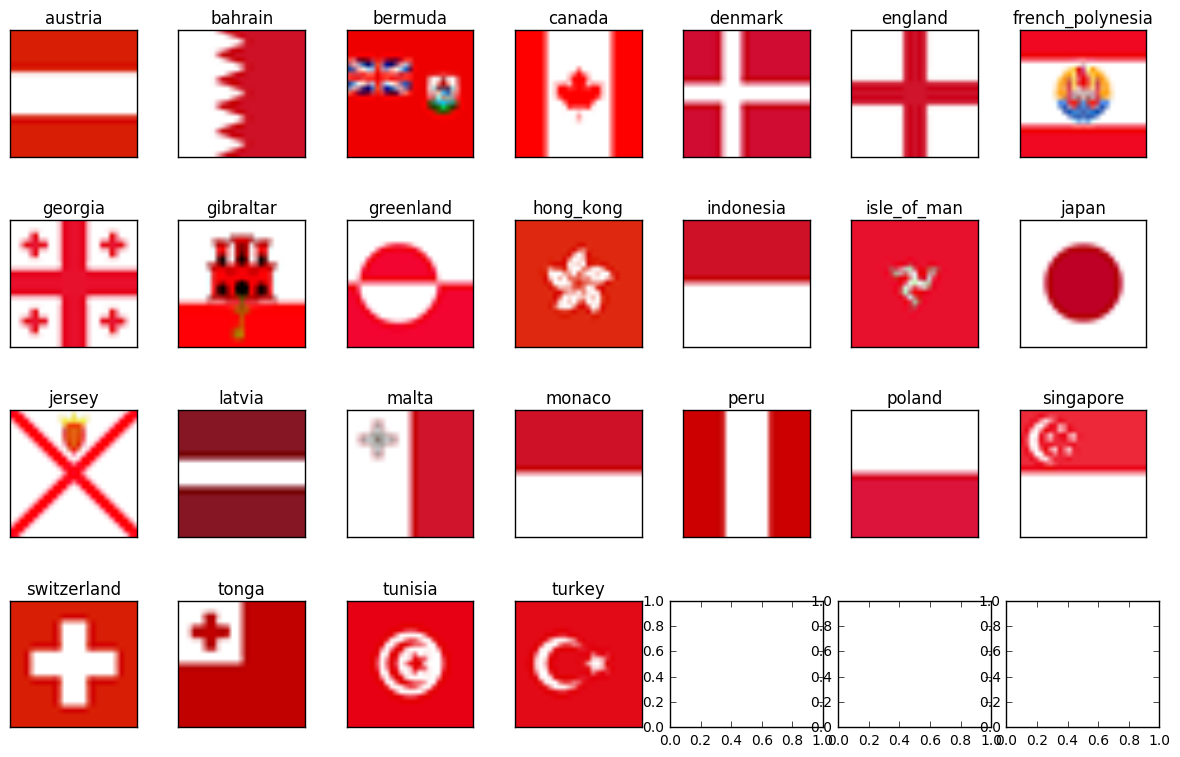

In [18]:

fig, axs = plt.subplots(int(np.ceil(len(red_and_white_flags)/7)), 7, figsize=(15, 9), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)

axs = axs.ravel()

for i, flag in enumerate(red_and_white_flags):
    flag_image = cv2.cvtColor(cv2.imread('flags/'+flag[0]+'.png'), cv2.COLOR_BGR2RGB)
    
    axs[i].imshow(flag_image)
    axs[i].set_yticklabels([])
    axs[i].set_xticklabels([])
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].set_title(flag[0])
